In [1]:
import _init_paths

In [2]:
import datasets.dataset.jde as JDE
from datasets.dataset.jde import JointDataset
import torch
import torch.utils.data
from torchvision.transforms import transforms as T
from models.model import create_model, load_model, save_model
import importlib
importlib.reload(JDE)

<module 'datasets.dataset.jde' from '/workspace/Github_5AUA0_Project_G12T1/FairMOT/src/lib/datasets/dataset/jde.py'>

In [3]:
from opts import opts
import sys
sys.argv = ['/opt/conda/envs/dcnv2/lib/python3.8/site-packages/ipykernel_launcher.py', 'mot']
print(sys.argv)
sys.argv.append('--batch_size')
sys.argv.append('1')
sys.argv.append('--arch')
sys.argv.append('hrnet_18')

['/opt/conda/envs/dcnv2/lib/python3.8/site-packages/ipykernel_launcher.py', 'mot']


In [4]:
opt = opts().parse(args='')

Fix size testing.
training chunk_sizes: [0, 1]
The output will be saved to  /workspace/Github_5AUA0_Project_G12T1/FairMOT/src/lib/../../exp/mot/default


## load dataset

In [5]:
trainset_paths = {"mot17": "./data/mot17.training"}
dataset_root = '/workspace/datasets/'
transforms = T.Compose([T.ToTensor()])
dataset = JointDataset(
    opt, dataset_root, trainset_paths, (1088, 608), augment=True, transforms=transforms
)
opt = opts().update_dataset_info_and_set_heads(opt, dataset)

dataset summary
OrderedDict([('mot17', 547.0)])
total # identities: 548
start index
OrderedDict([('mot17', 0)])
heads {'hm': 1, 'wh': 2, 'id': 512, 'reg': 2}


In [6]:
  train_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=opt.batch_size,
        shuffle=True,
        num_workers=opt.num_workers,
        pin_memory=True,
        drop_last=True,
    )

## load model

In [7]:
model = create_model(opt.arch, opt.heads, opt.head_conv)

{'hm': 1, 'wh': 2, 'id': 512, 'reg': 2}


In [8]:
start_epoch = 0
optimizer = torch.optim.Adam(model.parameters(), opt.lr)
if opt.load_model != "":
    model, optimizer, start_epoch = load_model(
        model, opt.load_model, optimizer, opt.resume, opt.lr, opt.lr_step
    )


## visualize model outputs and ground truth
model expects dict as input with following keys:

* input augmented image
* hm: heatmap that is generated from gaussian kernel using ground truth
* reg_mask: image prediction takes at max K objects which is zero filled, this mask either 1 or 0 depending if annotation was used at index 
* ind: integer index of image using  int(y)*w_output + int(x)
* wh: width height object
* reg:  width height offset, float(x,y) - int(x,y)
* ids: track id

In [9]:
print(opt.batch_size)
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection
plt.rcParams["figure.figsize"] = (10,10) #nice big plots
import numpy as np
from torchvision.transforms import ToPILImage

1


In [10]:
def indtoxy(ind, ratio=4, input_w=1088, input_h=608):
    if ind != 0:
        w_out, h_out = divmod(ind,input_w//ratio)
        #print(f"out: ({w_out},{h_out})")
        return w_out*ratio, h_out*ratio
    else:
        return None

In [11]:
def wh_decode(wh_tensor, ratio=4):
    wh_numpy = wh_tensor.cpu().numpy()
    wh_numpy_decode = np.rint(ratio*wh_numpy)
    return wh_numpy_decode[0], wh_numpy_decode[1]

0
dict_keys(['input', 'hm', 'reg_mask', 'ind', 'wh', 'reg', 'ids'])
tensor([ 6.2953, 13.2381])
x: 532, y: 216
w: 25.0, h: 53.0
x_plt: 519.5, y_plt: 189.5
tensor([ 4.5550, 10.1345])
x: 568, y: 212
w: 18.0, h: 41.0
x_plt: 559.0, y_plt: 191.5
tensor([3.7677, 9.5477])
x: 592, y: 212
w: 15.0, h: 38.0
x_plt: 584.5, y_plt: 193.0
tensor([18.0726, 45.6806])
x: 272, y: 244
w: 72.0, h: 183.0
x_plt: 236.0, y_plt: 152.5
tensor([ 9.8311, 19.2294])
x: 808, y: 248
w: 39.0, h: 77.0
x_plt: 788.5, y_plt: 209.5
tensor([ 6.3968, 11.8479])
x: 652, y: 224
w: 26.0, h: 47.0
x_plt: 639.0, y_plt: 200.5
tensor([3.8716, 9.0415])
x: 572, y: 212
w: 15.0, h: 36.0
x_plt: 564.5, y_plt: 194.0
tensor([ 7.5559, 15.0463])
x: 832, y: 256
w: 30.0, h: 60.0
x_plt: 817.0, y_plt: 226.0
tensor([2.8106, 7.8407])
x: 560, y: 208
w: 11.0, h: 31.0
x_plt: 554.5, y_plt: 192.5
tensor([ 4.4744, 10.0535])
x: 732, y: 232
w: 18.0, h: 40.0
x_plt: 723.0, y_plt: 212.0
tensor([ 5.3363, 13.2250])
x: 504, y: 208
w: 21.0, h: 53.0
x_plt: 493.5, y_pl

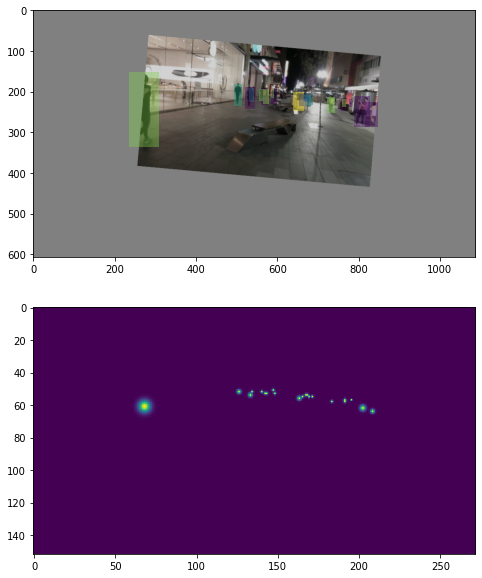

In [16]:
for iter_id, batch in enumerate(train_loader):
    print(iter_id)


    print(batch.keys())
    img_tensor = batch['input'][0,:,:,:] 
    #img  = batch['input'][0,:,:,:].cpu().numpy().reshape(608,1088,3)
    to_pil = ToPILImage()
    img_pil = to_pil(img_tensor)
    img_np =  np.array(img_pil)


    patcheslist = []
    #plot bounding boxes
    for i in range(128):
        if batch['reg_mask'][0,i].cpu().numpy():
            y,x = indtoxy(batch['ind'][0,i].cpu().numpy())
            print(batch['wh'][0,i])
            w,h = wh_decode(batch['wh'][0,i])
            #print(batch['ind'][0,i])
            #print(indtoxy(batch['ind'][0,i].cpu().numpy()))
            #w, h = indtoxy(batch['ind'][0,i].cpu().numpy())
            print(f"x: {x}, y: {y}")
            print(f"w: {w}, h: {h}")
            x_plt = x - 0.5*w   # left coordinate
            y_plt = y - 0.5*h # bottom coordinate
            print(f"x_plt: {x_plt}, y_plt: {y_plt}")
            patcheslist.append(patches.Rectangle((x_plt,y_plt),w,h,linewidth=1,edgecolor='r',facecolor='none'))


    # Create figure and axes
    fig, (ax1,ax2) = plt.subplots(2)

    colors = 100*np.random.rand(len(patcheslist))
    p = PatchCollection(patcheslist, alpha=0.4)
    p.set_array(np.array(colors))
    ax1.add_collection(p)


    # Display the image
    ax1.imshow(img_np)

    # Create a Rectangle patch
    #rect = patches.Rectangle((50,100),40,30,linewidth=1,edgecolor='r',facecolor='none')

    # Add the patch to the Axes
    #ax1.add_patch(rect)
    print(batch['hm'].shape)
    ax2.imshow(batch['hm'][0,0,:,:])
    plt.show()
    break

 